In [6]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load('Mg22_size512_convertXYZQ_train.npy')


In [7]:
import random

num_chunks = 8  # or adjust based on your data's dimensions
points_per_chunk = 32  # or adjust as needed
z_dim = data.shape[0]  # z-dimension of your data

print(z_dim)
start_points = random.sample(range(z_dim - points_per_chunk + 1), num_chunks)


2015


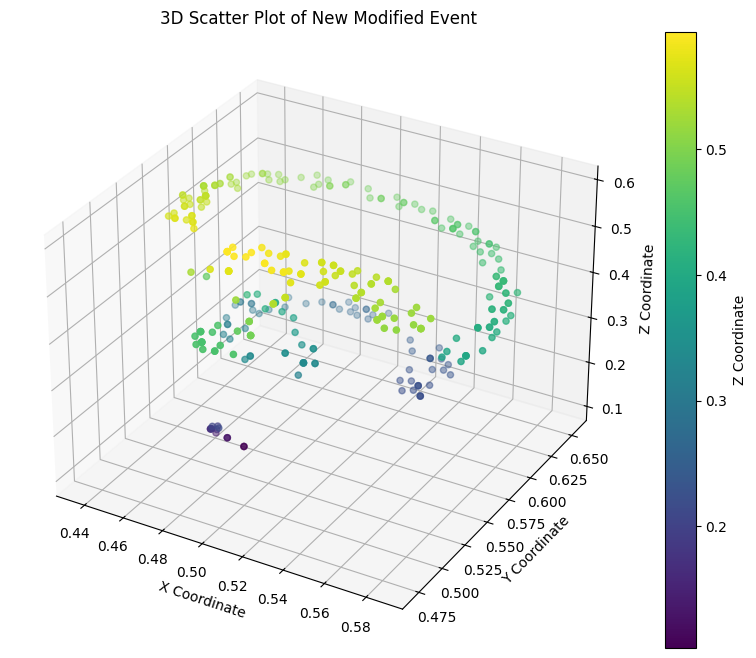

In [8]:
# Re-defining the remove_points_in_segments function
def remove_points_in_segments(event, num_segments, total_points_to_remove):
    # Determine the number of points to remove per segment
    points_per_segment = total_points_to_remove // num_segments

    # Get the range of Z values
    z_min, z_max = np.min(event[:, 2]), np.max(event[:, 2])
    segment_size = (z_max - z_min) / num_segments

    modified_event = event.copy()

    for i in range(num_segments):
        # Define the segment bounds
        z_lower = z_min + i * segment_size
        z_upper = z_lower + segment_size

        # Select points within this segment
        segment_mask = (modified_event[:, 2] >= z_lower) & (modified_event[:, 2] < z_upper)
        segment_points = modified_event[segment_mask]

        # Randomly remove points from this segment
        if len(segment_points) > points_per_segment:
            points_to_remove = np.random.choice(range(len(segment_points)), points_per_segment, replace=False)
            segment_points = np.delete(segment_points, points_to_remove, axis=0)

        # Update the modified event
        modified_event = np.concatenate([modified_event[~segment_mask], segment_points])

    return modified_event

first_event = data[0, :, :]  # This selects the first event from your data


# Apply the function to the first event
modified_event_v2 = remove_points_in_segments(first_event, 8, 256)

# 3D Plotting the new modified event
x_mod_v2 = modified_event_v2[:, 0]
y_mod_v2 = modified_event_v2[:, 1]
z_mod_v2 = modified_event_v2[:, 2]

# Creating the 3D scatter plot again
fig_v2 = plt.figure(figsize=(10, 8))
ax_v2 = fig_v2.add_subplot(111, projection='3d')
scatter_v2 = ax_v2.scatter(x_mod_v2, y_mod_v2, z_mod_v2, c=z_mod_v2, cmap='viridis')
plt.colorbar(scatter_v2, ax=ax_v2, label='Z Coordinate')
ax_v2.set_xlabel('X Coordinate')
ax_v2.set_ylabel('Y Coordinate')
ax_v2.set_zlabel('Z Coordinate')
ax_v2.set_title('3D Scatter Plot of New Modified Event')
plt.show()


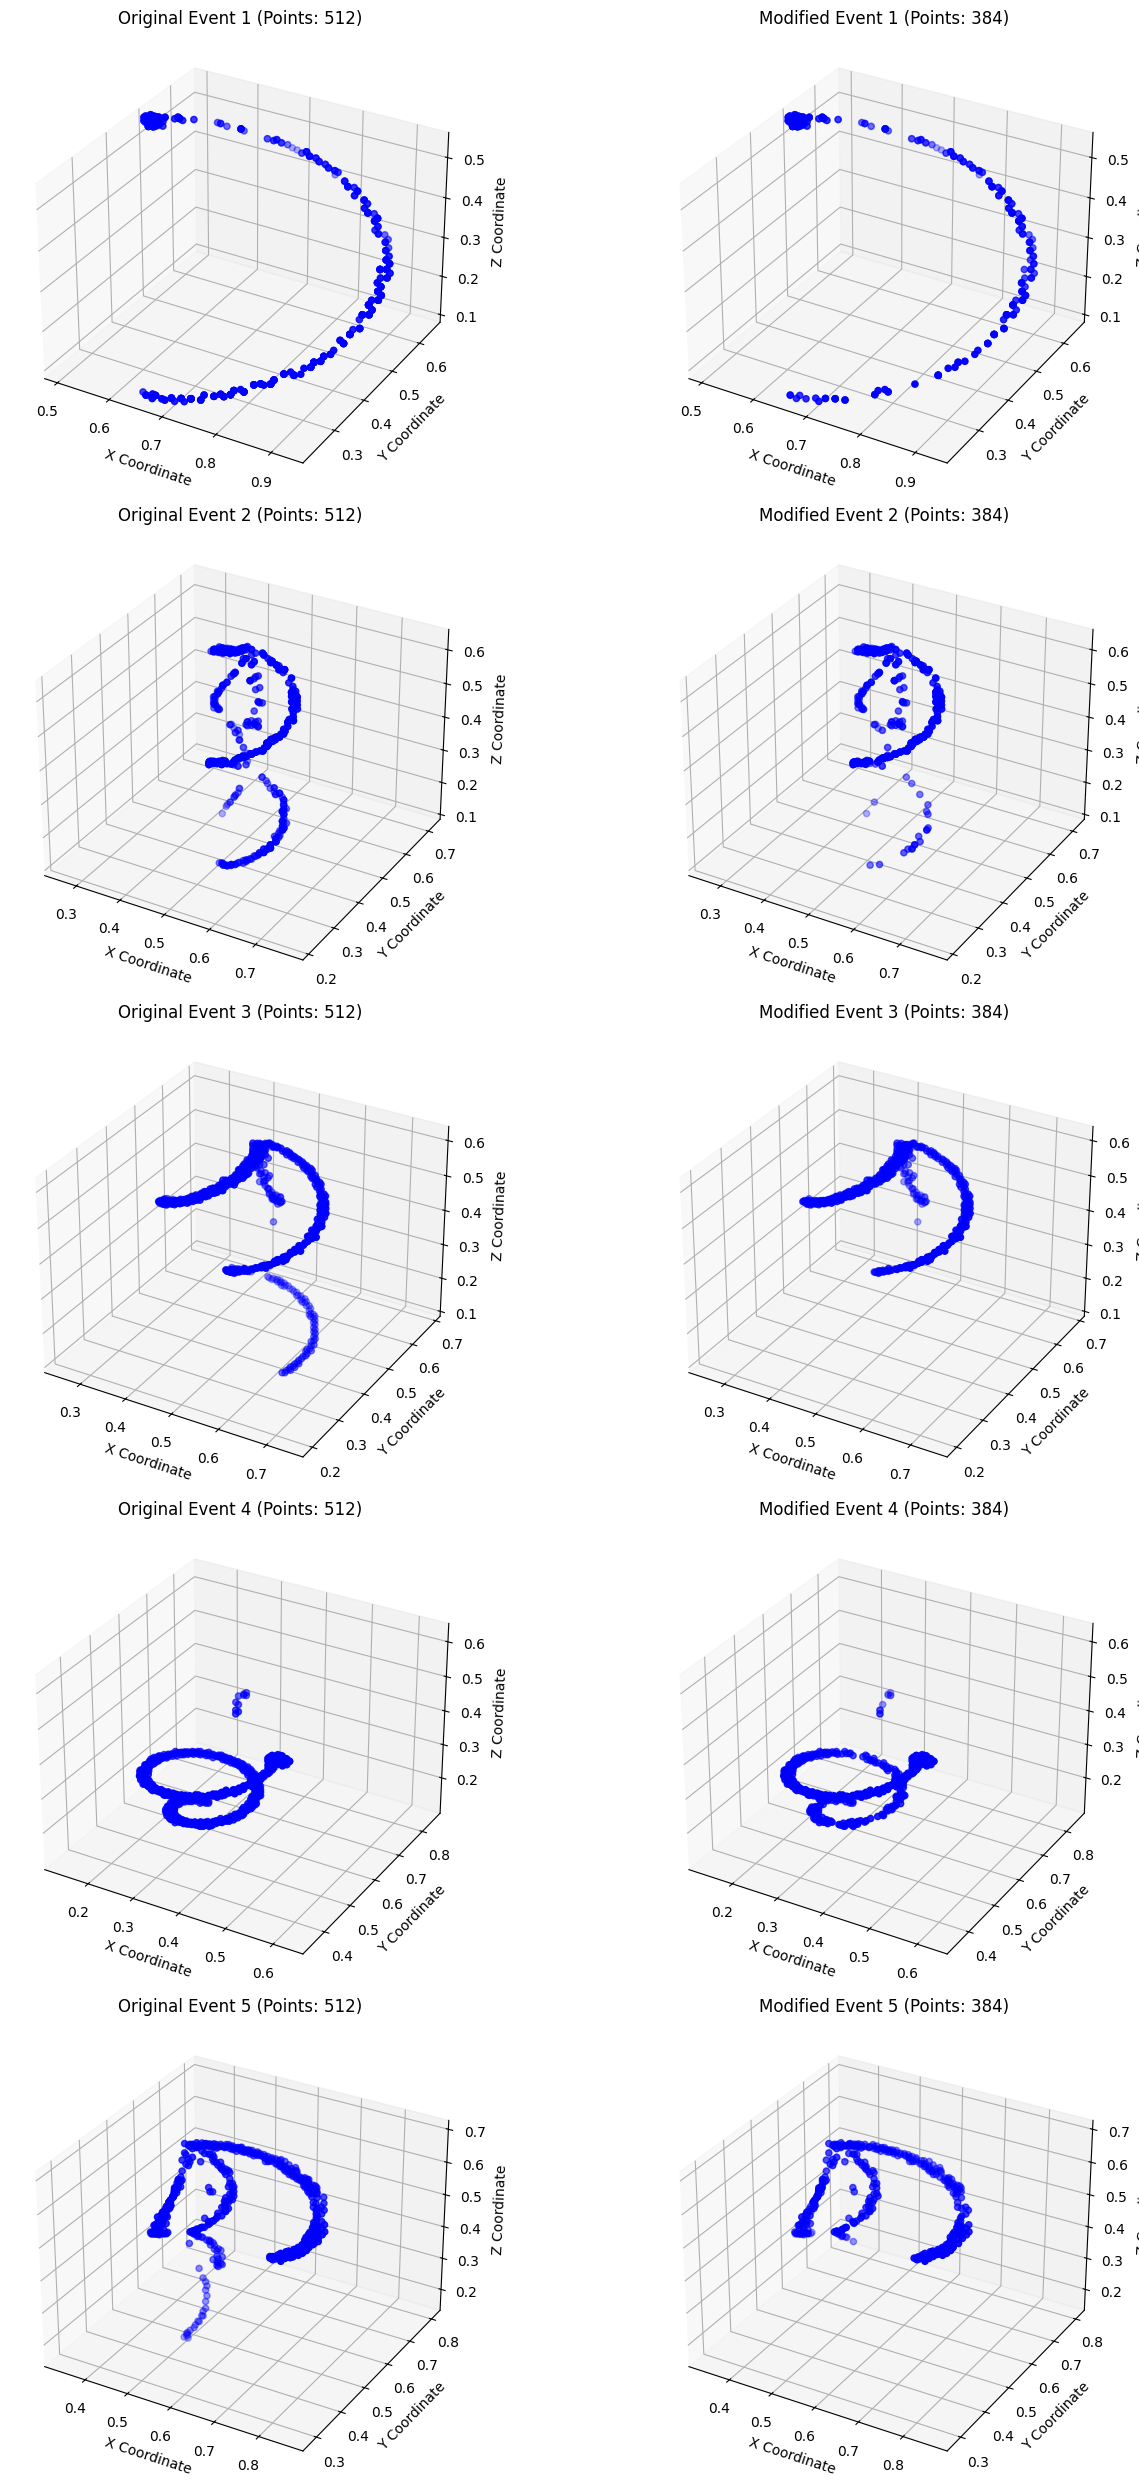

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Load your data
data = np.load('Mg22_size512_convertXYZQ_train.npy')  # Replace with your file path

# Function to remove exactly 256 points from an event in segments
def remove_points_in_segments_exact(event, num_segments, total_points_to_remove):
    if len(event) <= total_points_to_remove:
        raise ValueError("The event does not have enough points to remove the specified number.")

    z_min, z_max = np.min(event[:, 2]), np.max(event[:, 2])
    segment_size = (z_max - z_min) / num_segments
    modified_event = event.copy()

    removed_points = 0
    for i in range(num_segments):
        if removed_points >= total_points_to_remove:
            break

        z_lower = z_min + i * segment_size
        z_upper = z_lower + segment_size if i < num_segments - 1 else z_max + 1

        segment_mask = (modified_event[:, 2] >= z_lower) & (modified_event[:, 2] < z_upper)
        segment_points = modified_event[segment_mask]

        points_to_remove = min(len(segment_points), total_points_to_remove - removed_points)
        if points_to_remove > 0:
            removed_indices = np.random.choice(len(segment_points), points_to_remove, replace=False)
            modified_event = np.delete(modified_event, np.nonzero(segment_mask)[0][removed_indices], axis=0)
            removed_points += points_to_remove

    return modified_event

# Function to plot an event
def plot_event_with_count(event, title, ax, min_max_range):
    ax.scatter(event[:, 0], event[:, 1], event[:, 2], color='blue', marker='o')
    ax.set_title(f'{title} (Points: {event.shape[0]})')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    # Setting the same scale for the axis
    mid_x, mid_y, mid_z = (min_max_range[0] + min_max_range[1]) / 2, (min_max_range[2] + min_max_range[3]) / 2, (min_max_range[4] + min_max_range[5]) / 2
    ax.set_xlim(mid_x - min_max_range[6], mid_x + min_max_range[6])
    ax.set_ylim(mid_y - min_max_range[6], mid_y + min_max_range[6])
    ax.set_zlim(mid_z - min_max_range[6], mid_z + min_max_range[6])

# Function to get the min, max and range for the axis
def get_min_max_range(event1, event2):
    min_max_range = [min(event1[:, 0].min(), event2[:, 0].min()), max(event1[:, 0].max(), event2[:, 0].max()),
                     min(event1[:, 1].min(), event2[:, 1].min()), max(event1[:, 1].max(), event2[:, 1].max()),
                     min(event1[:, 2].min(), event2[:, 2].min()), max(event1[:, 2].max(), event2[:, 2].max())]
    max_range = max(min_max_range[1] - min_max_range[0], min_max_range[3] - min_max_range[2], min_max_range[5] - min_max_range[4]) / 2
    min_max_range.append(max_range)
    return min_max_range

# Choose number of events to process
num_events_to_process = 5
random_indices = np.random.choice(data.shape[0], num_events_to_process, replace=False)
selected_events = data[random_indices, :, :]

# Plotting
fig, axs = plt.subplots(num_events_to_process, 2, figsize=(15, num_events_to_process * 5), subplot_kw={'projection': '3d'})

for i, event in enumerate(selected_events):
    try:
        modified_event = remove_points_in_segments_exact(event, 2, 128)
        min_max_range = get_min_max_range(event, modified_event)
        plot_event_with_count(event, f'Original Event {i+1}', axs[i, 0], min_max_range)
        plot_event_with_count(modified_event, f'Modified Event {i+1}', axs[i, 1], min_max_range)
    except ValueError as e:
        axs[i, 0].text2D(0.5, 0.5, str(e), ha='center')
        axs[i, 1].text2D(0.5, 0.5, str(e), ha='center')

plt.tight_layout()
plt.show()


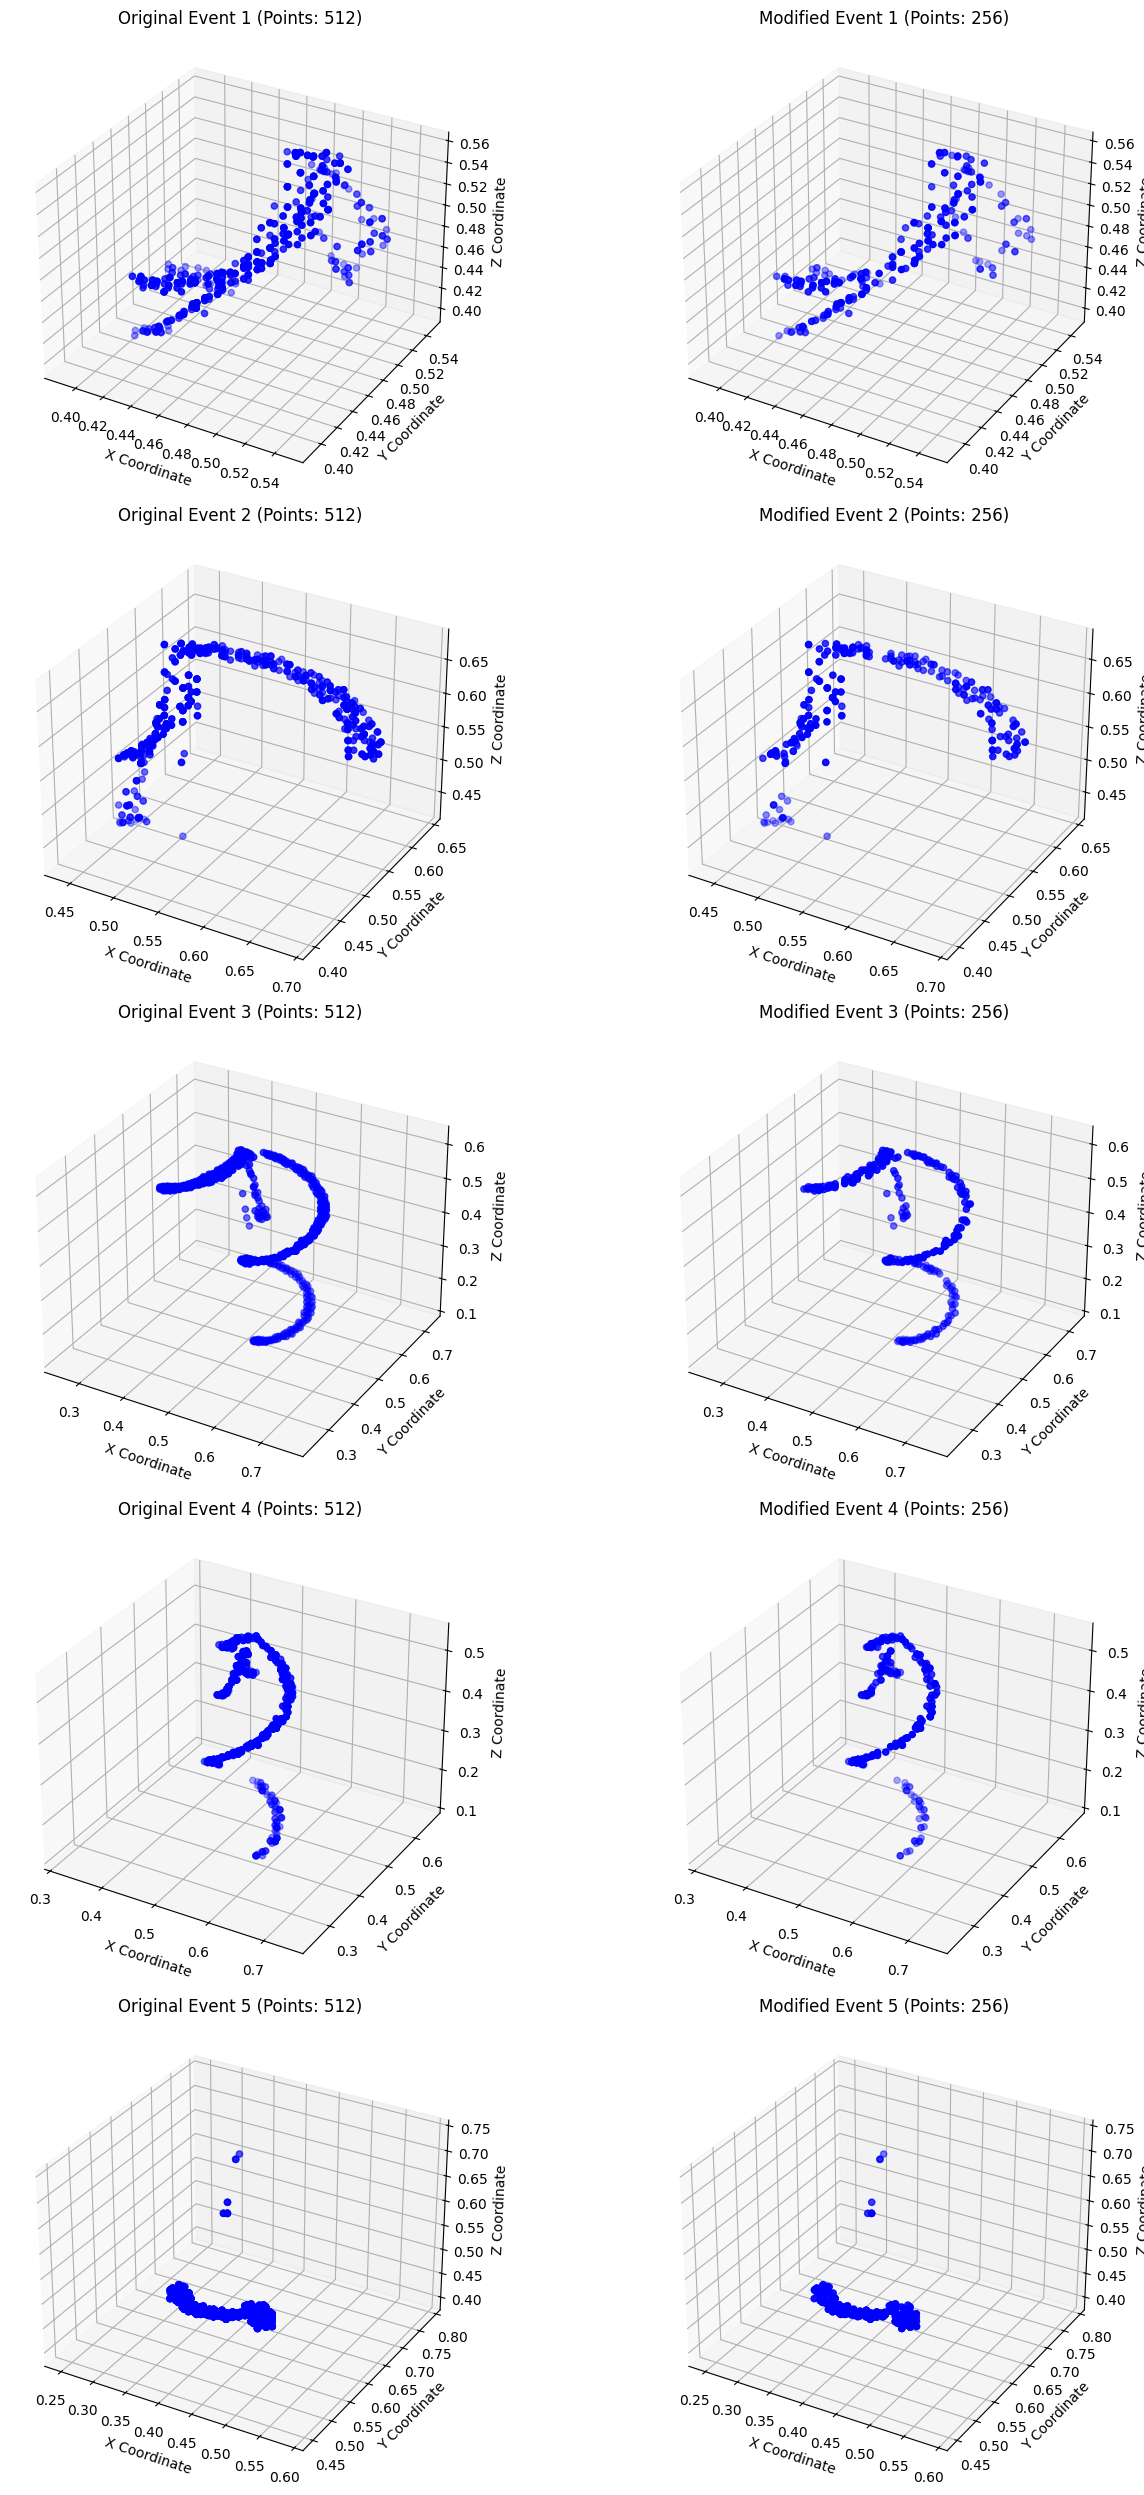

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# Load your data
data = np.load('Mg22_size512_convertXYZQ_train.npy')  # Replace with your file path

# Function to remove exactly 256 points from an event in segments

# Define the random_chunk_cut function
def random_chunk_cut(event, nChunks, chunkSize):
    rng = np.random.default_rng()
    total_length = len(event)
    chunk_starts = []
    for i in range(nChunks):
        slice_idx = int(rng.random() * total_length)
        while slice_idx > (total_length - chunkSize) or any(abs(start - slice_idx) < chunkSize for start in chunk_starts):
            slice_idx = int(rng.random() * total_length)
        chunk_starts.append(slice_idx)
    chunk_starts.sort(reverse=True)
    for start in chunk_starts:
        end = start + chunkSize
        event = np.delete(event, np.s_[start:end], axis=0)
    return event


# Function to plot an event
def plot_event_with_count(event, title, ax, min_max_range):
    ax.scatter(event[:, 0], event[:, 1], event[:, 2], color='blue', marker='o')
    ax.set_title(f'{title} (Points: {event.shape[0]})')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    # Setting the same scale for the axis
    mid_x, mid_y, mid_z = (min_max_range[0] + min_max_range[1]) / 2, (min_max_range[2] + min_max_range[3]) / 2, (min_max_range[4] + min_max_range[5]) / 2
    ax.set_xlim(mid_x - min_max_range[6], mid_x + min_max_range[6])
    ax.set_ylim(mid_y - min_max_range[6], mid_y + min_max_range[6])
    ax.set_zlim(mid_z - min_max_range[6], mid_z + min_max_range[6])

# Function to get the min, max and range for the axis
def get_min_max_range(event1, event2):
    min_max_range = [min(event1[:, 0].min(), event2[:, 0].min()), max(event1[:, 0].max(), event2[:, 0].max()),
                     min(event1[:, 1].min(), event2[:, 1].min()), max(event1[:, 1].max(), event2[:, 1].max()),
                     min(event1[:, 2].min(), event2[:, 2].min()), max(event1[:, 2].max(), event2[:, 2].max())]
    max_range = max(min_max_range[1] - min_max_range[0], min_max_range[3] - min_max_range[2], min_max_range[5] - min_max_range[4]) / 2
    min_max_range.append(max_range)
    return min_max_range
# Choose number of events to process
num_events_to_process = 5  # You can adjust this as needed
random_indices = np.random.choice(data.shape[0], num_events_to_process, replace=False)
selected_events = data[random_indices, :, :]

# Plotting
fig, axs = plt.subplots(num_events_to_process, 2, figsize=(15, num_events_to_process * 5), subplot_kw={'projection': '3d'})

for i, event in enumerate(selected_events):
    try:
        modified_event = random_chunk_cut(event, 4, 64)  # 4 chunks, 64 points each
        min_max_range = get_min_max_range(event, modified_event)
        plot_event_with_count(event, f'Original Event {i+1}', axs[i, 0], min_max_range)
        plot_event_with_count(modified_event, f'Modified Event {i+1}', axs[i, 1], min_max_range)
    except ValueError as e:
        axs[i, 0].text2D(0.5, 0.5, str(e), ha='center')
        axs[i, 1].text2D(0.5, 0.5, str(e), ha='center')

plt.tight_layout()
plt.show()


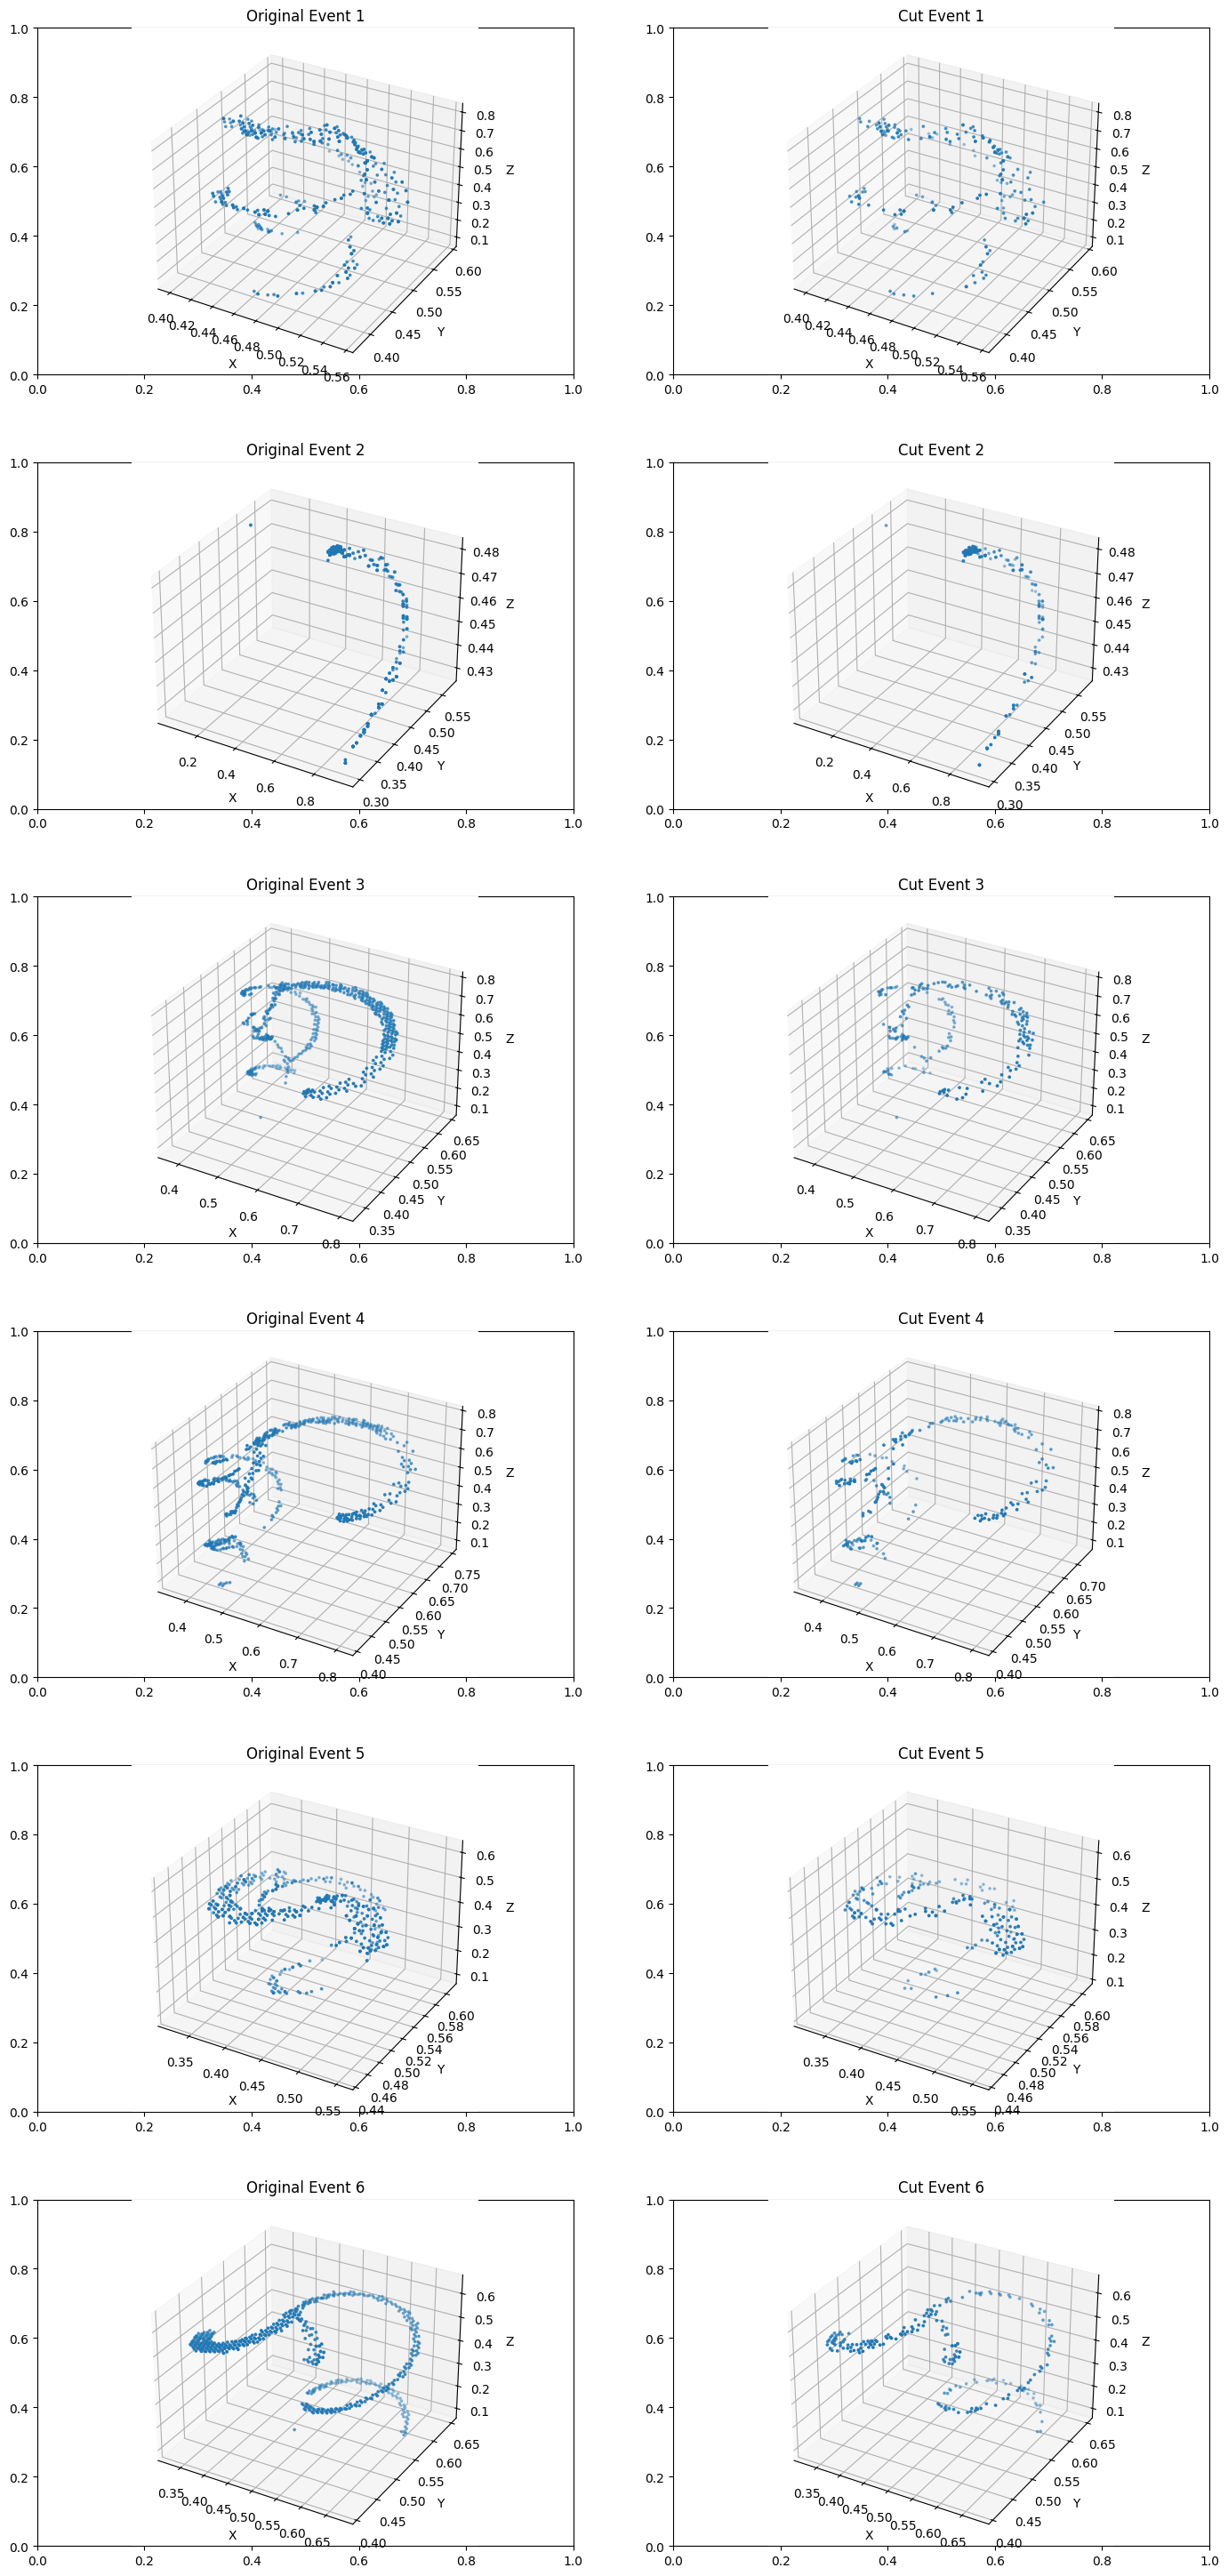

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the random_cut function
def random_cut(event, nSliced):
    rng = np.random.default_rng()
    slice_idx = int(rng.random() * len(event))
    # Ensure no out of bounds indexing
    while slice_idx > (len(event) - nSliced):
        slice_idx = int(rng.random() * len(event))
    last_idx = slice_idx + nSliced
    return np.delete(event, np.s_[slice_idx:last_idx], axis=0)

# Define the function to handle operations for a single file
def process_and_plot(file_path, nCut):
    # Load the data from the file
    data = np.load(file_path)
    
    # Pick 6 random events from the data
    rng = np.random.default_rng()
    random_indices = rng.choice(data.shape[0], 6, replace=False)
    random_events = data[random_indices]
    
    # Initialize the figure for plotting
    fig, axs = plt.subplots(6, 2, figsize=(15, 30))
    fig.tight_layout(pad=5.0)
    
    for i, event in enumerate(random_events):
        # Perform the random cut on the event
        cut_event = random_cut(event, nCut)
        
        # Plot the original event
        axs[i, 0].set_title(f'Original Event {i+1}')
        axs[i, 0] = fig.add_subplot(6, 2, i*2 + 1, projection='3d')
        axs[i, 0].scatter(event[:, 0], event[:, 1], event[:, 2], s=3)  # Increased point size here
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 0].set_zlabel('Z')
        
        # Plot the cut event
        axs[i, 1].set_title(f'Cut Event {i+1}')
        axs[i, 1] = fig.add_subplot(6, 2, i*2 + 2, projection='3d')
        axs[i, 1].scatter(cut_event[:, 0], cut_event[:, 1], cut_event[:, 2], s=3)  # Increased point size here
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].set_zlabel('Z')
    
    plt.show()


# Update the file path accordingly
file_path = 'Mg22_size512_convertXYZQ_train.npy'  # Replace with your file path
nCut = 300  # Number of points to cut

# Call the function to process and plot the data for the specified file
process_and_plot(file_path, nCut)


In [21]:
import numpy as np
import os

def restructure_and_sort(event):

    dtype = [('x', float), ('y', float), ('z', float)]

    restructured = np.empty((len(event), ), dtype=dtype)
    xs = event[:, 0]
    ys = event[:, 1]
    zs = event[:, 2]

    for i in range(len(event)):
        restructured[i] = (xs[i], ys[i], zs[i])

    restructured = np.sort(restructured, order='z')

    return restructured


def z_slice_event(event, nSliced, slices):

    nSliced //= slices

    while slices != 0:

        rng = np.random.default_rng()

        slice_idx = int(rng.random() * len(event))

        while slice_idx > (len(event) - nSliced) or slice_idx < nSliced:
            slice_idx = int(rng.random() * len(event))

        last_idx = slice_idx + nSliced

        sliced_event = np.delete(event, np.s_[slice_idx:last_idx:], axis=0)

        slices -= 1

    np.random.default_rng().shuffle(sliced_event)

    return sliced_event


def revert_structure(event):

    reverted = np.empty((1, len(event), 3))

    for i in range(len(event)):
        reverted[0, i, 0] = event[i]['x']
        reverted[0, i, 1] = event[i]['y']
        reverted[0, i, 2] = event[i]['z']

    return reverted



if __name__ == '__main__':
    
    root = ''

    files = [root+'Mg22_size512_convertXYZQ_train.npy',
             root+'Mg22_size512_convertXYZQ_test.npy',
             root+'Mg22_size512_convertXYZQ_val.npy']
    
    nSliced = 256
    slices = 2
    
    for file in files:

        f = np.load(file)

        cut_file = revert_structure(z_slice_event(restructure_and_sort(f[0]), nSliced, slices))

        for i in range(1, len(f)):
            cut_event = restructure_and_sort(f[i])
            cut_event = z_slice_event(cut_event, nSliced, slices)
            cut_event = revert_structure(cut_event)
            cut_file = np.vstack((cut_file, cut_event))

        if 'test' in file:
            split = 'test.npy'
        elif 'train' in file:
            split = 'train.npy'
        elif 'val' in file:
            split = 'val.npy'
        else:
            assert False, 'train, test, or val not in filename'

        np.save(root+'256p/Mg22_zsliced_size128_'+split, cut_file)

        
